# Final Project - PHYS 555 - Instructor: Seb Fabbro

## Breanna Crompvoets and Samuel Fielder

In [16]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# classic ML libraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,  GridSearchCV
import xgboost as xgb

# custom made libraries
from custom_dataloader import replicate_data

# Classical ML Techniques

> 

In [2]:
# settings for plotting in this section

cm_blues = plt.cm.Blues
custom_labs = ['Class 1', 'Class 2', 'Others']

> Need to say somewhere here that we ran the GridSearchCV with a large range of hyperparameters, but in this notebook we do not perform the grid search and just use the found hyperparameters are defaults. We still plug them into a GridSearchCV just to show that we are able to perform this task. AYEEEEEEEEEEE.

## Loading Data Set

In [3]:
# data load
X = np.load("Data/Input_Class_AllClasses_Sep.npy")
Y = np.load("Data/Target_Class_AllClasses_Sep.npy")

# custom data loader to pull in custom sized data set
# use seed to get replicable results for now
seed_val = 1111

# the amounts here are how many of each class of object you want in the training set and validation set
# leftover amount get's dumped into testing set

#amounts_train = [331,1141,231,529,27,70,1257]
amounts_train = [300,300,300,300,27,70,300]
amounts_val = [82, 531, 104, 278, 6, 17, 4359]

inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, 'three', amounts_train, amounts_val, seed_val)

print('Sizes of Datasets : Inputs , Targets')
print('------------------------------------')
print(f'Training set: {inp_tr.shape} , {tar_tr.shape} \nValidation set: {inp_va.shape} , {tar_va.shape} \nTesting Set: {inp_te.shape}, {tar_te.shape}')
print('------------------------------------')

Sizes of Datasets : Inputs , Targets
------------------------------------
Training set: (1597, 8) , (1597,) 
Validation set: (5377, 8) , (5377,) 
Testing Set: (19929, 8), (19929,)
------------------------------------


/opt/anaconda3/envs/PHYS555_PY37/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [15]:
test = pd.DataFrame(inp_tr)
test['Label'] = tar_tr

print(test['Label'].value_counts())

2    997
1    300
0    300
Name: Label, dtype: int64


### Logistic Regression

In [5]:
%%time

# specifying pipeline for logistic regression
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

# hyperparameters
# param_grid = [{'logreg__penalty': ['l1'],
#                 'logreg__max_iter': [300],
#                 'logreg__solver': ['liblinear'],
#                 'logreg__tol': [0.0001]}]


param_grid = [{ 'logreg__penalty': ['l1'],
                'logreg__max_iter': [500],
                'logreg__solver': ['saga'],
                'logreg__tol': [0.0001]}]

# plug parameters into GridSearchCV
grid = GridSearchCV(pipe,param_grid=param_grid, verbose=1)

# run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/envs/PHYS555_PY37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


CPU times: user 801 ms, sys: 7.3 ms, total: 808 ms
Wall time: 802 ms


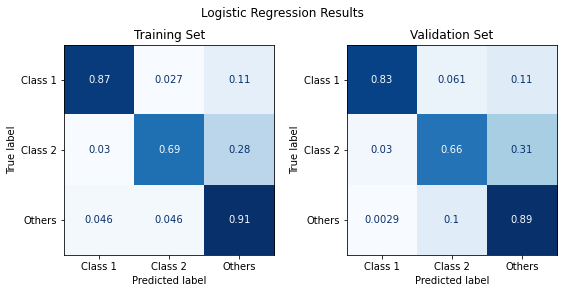

In [7]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Logistic Regression Results')
plt.tight_layout()
plt.show()

### SVM

In [8]:
%%time

# specifying pipeline for logistic regression
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

# hyperparameters
param_grid = [{'svc__kernel':['rbf',],
               'svc__gamma':['auto'],
               'svc__C': [0.9]}]

# plug parameters into GridSearchCV
grid = GridSearchCV(pipe,param_grid=param_grid)

# run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

CPU times: user 806 ms, sys: 11.6 ms, total: 818 ms
Wall time: 824 ms


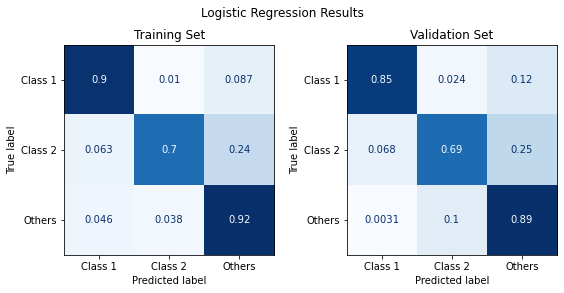

In [9]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Logistic Regression Results')
plt.tight_layout()
plt.show()

### Gradient Boosting

In [14]:
%%time

boostcl = GradientBoostingClassifier()
parameters = {'criterion': ['friedman_mse'],
                'max_depth': [9],
                'max_features': ['log2'],
                'n_estimators': [50],
                'n_iter_no_change': [5],
                'subsample': [1.0],
                'warm_start': [True]}

grid = GridSearchCV(boostcl, parameters)

# run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

CPU times: user 3.24 s, sys: 17.3 ms, total: 3.26 s
Wall time: 3.27 s


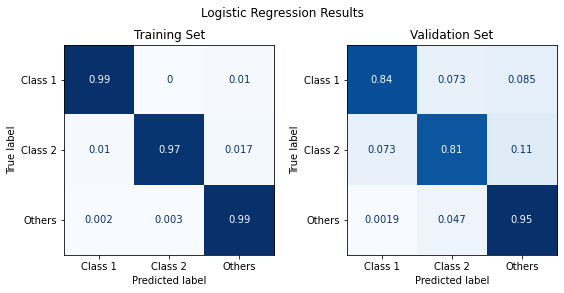

In [15]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Logistic Regression Results')
plt.tight_layout()
plt.show()

### XGBoost

In [19]:
xgbcl = xgb.XGBClassifier()
parameters = {'max_depth': [9], 'sampling_method': ['uniform'], 'subsample': [0.5]}

grid = GridSearchCV(xgbcl, parameters)

# run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

### Random Forest

In [17]:
# Specify the pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('rfcl', RandomForestClassifier())])

# Specify parameter space to test
param_grid = {'rfcl__class_weight': ['balanced_subsample'],
 'rfcl__criterion': ['entropy'],
 'rfcl__max_features': ['log2'],
 'rfcl__n_estimators': [150]}

# Define the grid
grid = GridSearchCV(pipe,param_grid=param_grid)

# run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

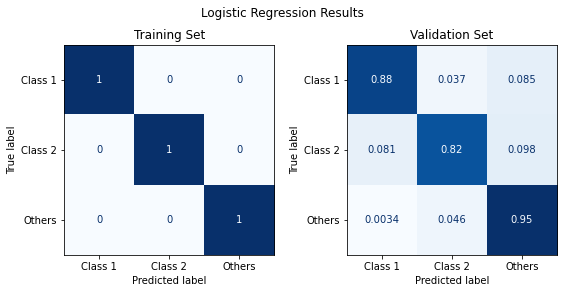

In [18]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.suptitle('Logistic Regression Results')
plt.tight_layout()
plt.show()